In [2]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer


df = pd.read_csv('../data_exploration/logistic_regress/cleaned_data.csv')

# HANDLE DUPLICATES
df = df.drop_duplicates()

# HANDLE SKEWED FEATURES
# Find skewed features, excluding the target 'NSP'
numeric_features = df.select_dtypes(include=np.number)
skewed_features = numeric_features.skew()
skewed_features = skewed_features[abs(skewed_features) > 1]
skewed_features = skewed_features.drop('NSP') # Exclude the target variable

# Apply Yeo-Johnson transformation to normalise data
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
df[skewed_features.index] = power_transformer.fit_transform(df[skewed_features.index])

# Drop any rows that might have NaN values after transformation
df = df.dropna()

# verify 
print("Data is now fully cleaned and preprocessed")
print(f"Remaining number of rows: {len(df)}")
df.info()

Data is now fully cleaned and preprocessed
Remaining number of rows: 2116
<class 'pandas.core.frame.DataFrame'>
Index: 2116 entries, 0 to 2125
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b         2116 non-null   float64
 1   e         2116 non-null   float64
 2   LB        2116 non-null   float64
 3   AC        2116 non-null   float64
 4   FM        2116 non-null   float64
 5   UC        2116 non-null   float64
 6   DL        2116 non-null   float64
 7   DS        2116 non-null   float64
 8   DP        2116 non-null   float64
 9   ASTV      2116 non-null   float64
 10  MSTV      2116 non-null   float64
 11  ALTV      2116 non-null   float64
 12  MLTV      2116 non-null   float64
 13  Width     2116 non-null   float64
 14  Min       2116 non-null   float64
 15  Max       2116 non-null   float64
 16  Nmax      2116 non-null   float64
 17  Nzeros    2116 non-null   float64
 18  Mode      2116 non-null   float64
 19  

In [4]:
print("Performing SELECTIVE outlier capping...")

# create list of columns where outliers might be critical signals
# dont cap these
critical_signal_cols = ['AC', 'FM', 'UC', 'DL', 'DS', 'DP'] 

# get all numeric columns
numeric_cols = df.drop(columns=['NSP']).select_dtypes(include=np.number).columns

for col in numeric_cols:
    if col not in critical_signal_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # cap the outliers
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

print("Selective outlier capping complete.")

Performing SELECTIVE outlier capping...
Selective outlier capping complete.


In [5]:
print("Creating smarter features based on medical context")

# Feature 1: Deceleration Severity
# Combines the impact of long decelerations with abnormal heart rate variability.
# A high value here is a potential red flag.
df['Deceleration_Severity'] = df['DP'] * df['ASTV']

# Feature 2: FHR Range
# The difference between the max and min heart rate in the trace.
# A very flat or very erratic range could be significant.
df['FHR_Range'] = df['Max'] - df['Min']

print("New features created.")

Creating smarter features based on medical context
New features created.


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, f1_score

print("Dropping leaky 'CLASS' feature and separating X and y")
X = df.drop(columns=['NSP', 'CLASS'])
y = df['NSP']

# split the data into training and testing sets
# use stratify=y to ensure both train and test sets have a similar class distribution.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data splitting complete.")

Dropping leaky 'CLASS' feature and separating X and y
Data splitting complete.


In [7]:
# split test set at 20% of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression


print("Performing feature selection...")

# Use a Logistic Regression model with an 'l1' penalty to select the most important features.
# This is a key step in preventing overfitting.
selector = SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1)).fit(X_train_scaled, y_train)

# Create new datasets containing only the selected features
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Selected number of features: {X_train_selected.shape[1]}")
print("Feature selection complete.")

Performing feature selection...
Original number of features: 35
Selected number of features: 21
Feature selection complete.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Graph has been saved as 'feature_importance_plot.png'


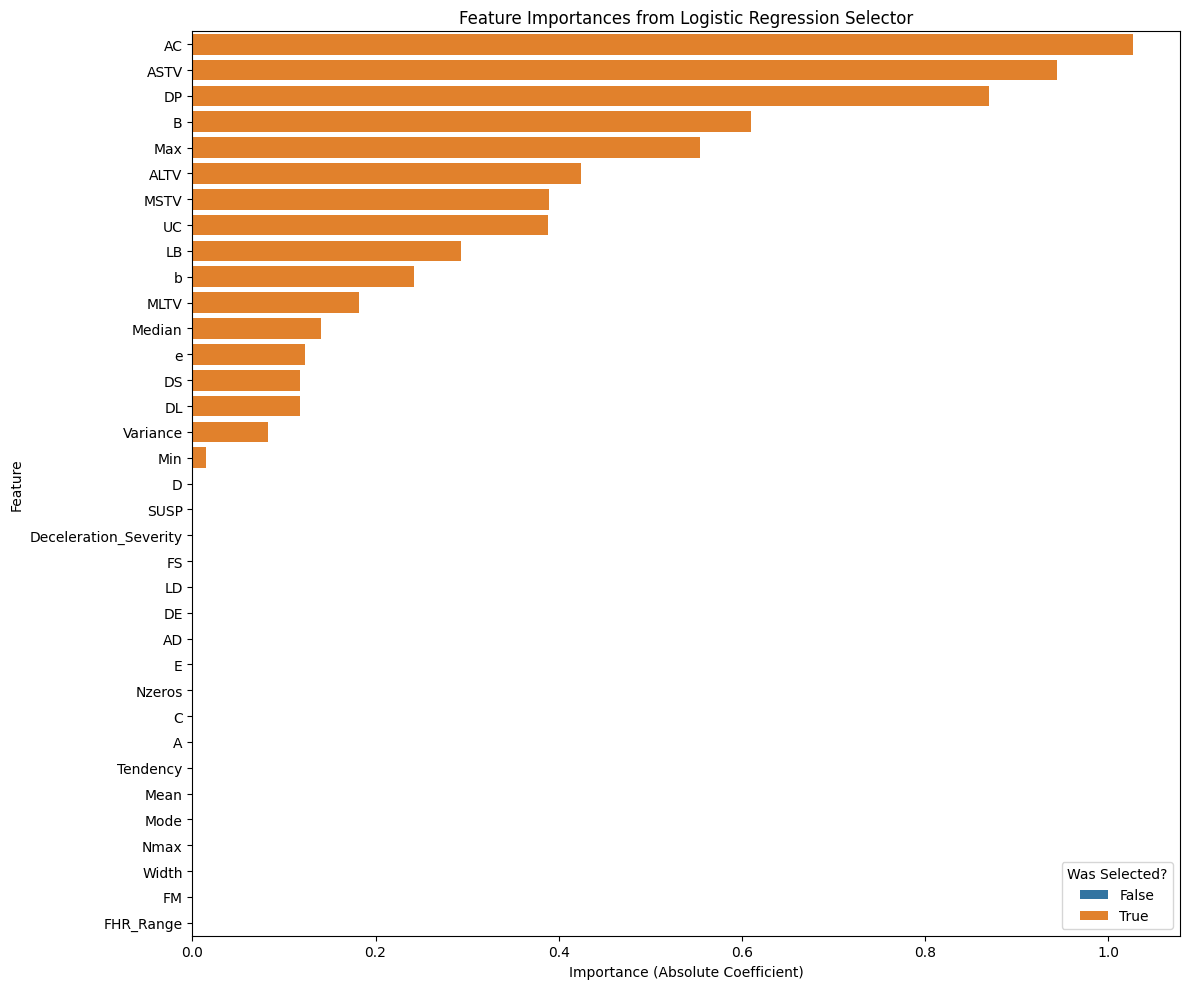

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


importances = np.abs(selector.estimator_.coef_[0])

# 2. Get the boolean mask of the selected features
selected_mask = selector.get_support()

# 3. Create a DataFrame for visualization
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Selected': selected_mask
})

# 4. Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 5. Create the bar plot
plt.figure(figsize=(12, 10))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df,
    hue='Selected',  # Color bars based on whether the feature was selected
    dodge=False      # Prevent bars from splitting based on hue
)

plt.title('Feature Importances from Logistic Regression Selector')
plt.xlabel('Importance (Absolute Coefficient)')
plt.ylabel('Feature')
plt.legend(title='Was Selected?', loc='lower right')
plt.tight_layout() # Adjust layout to make room for feature names

# Save the plot to an image file
plt.savefig('feature_importance_plot.png')

print("Graph has been saved as 'feature_importance_plot.png'")

In [10]:
# TRAIN FINAL MODEL WITH REGULARIZATION (to prevent overfitting)

final_model = LogisticRegression(C=0.1, max_iter=1000)
final_model.fit(X_train_selected, y_train)

# final model on the selected test data
predictions = final_model.predict(X_test_selected)

# Calculate the final scores 
bal_accuracy = balanced_accuracy_score(y_test, predictions)
macro_f1 = f1_score(y_test, predictions, average='macro')

print(f"\n--- Final Model Performance ---")
print(f"Balanced Accuracy: {bal_accuracy}")
print(f"Macro F1-Score: {macro_f1}")


--- Final Model Performance ---
Balanced Accuracy: 0.7792595441851922
Macro F1-Score: 0.7920803782505911


Overfitting comparison graph saved as 'final_learning_curve.png'


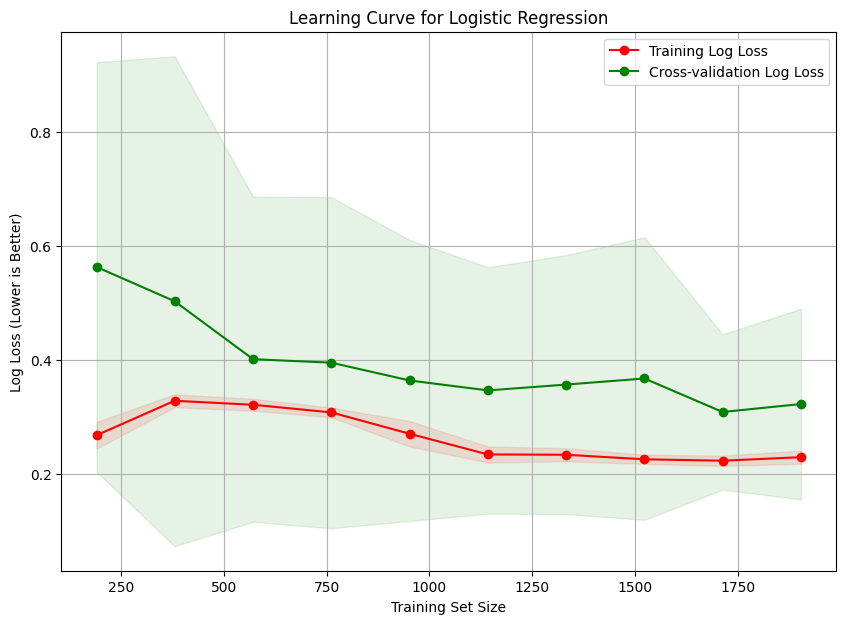

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


final_model_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=0.1, max_iter=1000)
)


train_sizes, train_scores, test_scores = learning_curve(
    estimator=final_model_pipeline,
    X=X,
    y=y,
    cv=10, 
    scoring='neg_log_loss',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.figure(figsize=(10, 7))
plt.grid()


plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")


plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Log Loss")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Log Loss")

plt.xlabel("Training Set Size")
plt.ylabel("Log Loss (Lower is Better)")
plt.title("Learning Curve for Logistic Regression")
plt.legend(loc="best")


plt.savefig('final_learning_curve.png')

print("Overfitting comparison graph saved as 'final_learning_curve.png'")

### Low Overfitting as lines are very close together. 
### Shaded area of cross validation is wide indicating unstable and inconsistent 
### Both lines have flattened out towards the right side of the graph. This indicates that the model has learned as much as it can from the features provided. performance converged to a stable Log Loss of around 0.3.


In [12]:
output_path = '../data_exploration/logistic_regress/final_processed_data.csv'


#use index=False to prevent pandas from writing the row numbers as a new column
df.to_csv(output_path, index=False)

print(f"Final clean data successfully saved to: {output_path}")

Final clean data successfully saved to: ../data_exploration/logistic_regress/final_processed_data.csv
